In [12]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from typing import List, Tuple


In [13]:
def load_berlin52_data(filename):
    """Load city coordinates from berlin52.tsp file"""
    cities = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        
    # Find the start of coordinates section
    coord_start = False
    for line in lines:
        line = line.strip()
        if line == "NODE_COORD_SECTION":
            coord_start = True
            continue
        if line == "EOF":
            break
        if coord_start and line:
            parts = line.split()
            if len(parts) >= 3:
                # Skip the city index, take x and y coordinates
                x, y = float(parts[1]), float(parts[2])
                cities.append((x, y))
    
    return cities

# Load the dataset
cities = load_berlin52_data('berlin52.tsp')
print(f"Loaded {len(cities)} cities from Berlin52 dataset")
print(f"First 5 cities: {cities[:5]}")

Loaded 52 cities from Berlin52 dataset
First 5 cities: [(565.0, 575.0), (25.0, 185.0), (345.0, 750.0), (945.0, 685.0), (845.0, 655.0)]


In [14]:
def euclidean_distance(city1, city2):
    """Calculate Euclidean distance between two cities"""
    return math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

def calculate_route_distance(route, cities):
    """Calculate total distance of a route"""
    total_distance = 0
    for i in range(len(route)):
        from_city = cities[route[i]]
        to_city = cities[route[(i + 1) % len(route)]]  # Return to start
        total_distance += euclidean_distance(from_city, to_city)
    return total_distance

# Test distance calculation
test_route = [0, 1, 2, 3, 4]
test_distance = calculate_route_distance(test_route, cities)
print(f"Test route {test_route} has distance: {test_distance:.2f}")

Test route [0, 1, 2, 3, 4] has distance: 2314.55


In [15]:
def create_route(num_cities):
    """Create a random route (chromosome)"""
    route = list(range(num_cities))
    random.shuffle(route)
    return route

def initial_population(population_size, num_cities):
    """Generate initial population of random routes"""
    population = []
    for _ in range(population_size):
        population.append(create_route(num_cities))
    return population

# Create initial population
POPULATION_SIZE = 100
NUM_CITIES = len(cities)
population = initial_population(POPULATION_SIZE, NUM_CITIES)

print(f"Created initial population of {len(population)} routes")
print(f"Example route: {population[0][:10]}...")  # Show first 10 cities

Created initial population of 100 routes
Example route: [36, 13, 10, 33, 12, 48, 40, 22, 45, 7]...


In [16]:
def fitness(route, cities):
    """Calculate fitness (inverse of distance - higher is better)"""
    distance = calculate_route_distance(route, cities)
    return 1 / distance

def rank_routes(population, cities):
    """Rank routes by fitness"""
    fitness_results = []
    for i, route in enumerate(population):
        fitness_results.append((i, fitness(route, cities)))
    return sorted(fitness_results, key=lambda x: x[1], reverse=True)

# Test fitness calculation
ranked_pop = rank_routes(population, cities)
best_route_idx = ranked_pop[0][0]
best_route = population[best_route_idx]
best_distance = calculate_route_distance(best_route, cities)

print(f"Best route in initial population has distance: {best_distance:.2f}")
print(f"Best fitness: {ranked_pop[0][1]:.8f}")

Best route in initial population has distance: 25732.47
Best fitness: 0.00003886


In [17]:
def tournament_selection(ranked_population, tournament_size=5):
    """Tournament selection method"""
    tournament = random.sample(ranked_population, tournament_size)
    return max(tournament, key=lambda x: x[1])[0]

def roulette_wheel_selection(ranked_population):
    """Roulette wheel selection method"""
    total_fitness = sum(fitness for _, fitness in ranked_population)
    pick = random.uniform(0, total_fitness)
    current = 0
    for route_id, fitness in ranked_population:
        current += fitness
        if current > pick:
            return route_id
    return ranked_population[-1][0]

def selection(ranked_population, population, elite_size=20):
    """Select parents for breeding"""
    selection_results = []
    
    # Keep elite individuals
    for i in range(elite_size):
        selection_results.append(population[ranked_population[i][0]])
    
    # Select remaining using tournament selection
    for _ in range(len(population) - elite_size):
        parent_index = tournament_selection(ranked_population)
        selection_results.append(population[parent_index])
    
    return selection_results

# Test selection
mating_pool = selection(ranked_pop, population)
print(f"Created mating pool of size: {len(mating_pool)}")

Created mating pool of size: 100


In [18]:
def order_crossover(parent1, parent2):
    """Order crossover (OX) - preserves city order"""
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    
    # Create child with segment from parent1
    child = [-1] * size
    child[start:end] = parent1[start:end]
    
    # Fill remaining positions with cities from parent2 in order
    parent2_filtered = [city for city in parent2 if city not in child]
    j = 0
    for i in range(size):
        if child[i] == -1:
            child[i] = parent2_filtered[j]
            j += 1
    
    return child

def crossover(mating_pool, elite_size= 20):
    """Create offspring through crossover"""
    children = []
    
    # Keep elite individuals
    for i in range(elite_size):
        children.append(mating_pool[i])
    
    # Create children through crossover
    for _ in range(len(mating_pool) - elite_size):
        parent1, parent2 = random.sample(mating_pool, 2)
        child = order_crossover(parent1, parent2)
        children.append(child)
    
    return children

# Test crossover
parent1 = population[0]
parent2 = population[1]
child = order_crossover(parent1, parent2)
print(f"Parent1: {parent1[:10]}...")
print(f"Parent2: {parent2[:10]}...")
print(f"Child:   {child[:10]}...")

Parent1: [36, 13, 10, 33, 12, 48, 40, 22, 45, 7]...
Parent2: [41, 10, 29, 44, 3, 7, 19, 8, 46, 32]...
Child:   [41, 10, 29, 44, 3, 48, 40, 22, 45, 7]...


In [19]:
def swap_mutation(individual, mutation_rate=0.1):
    """Swap mutation - swap two random cities"""
    mutated = individual.copy()
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(mutated)), 2)
        mutated[i], mutated[j] = mutated[j], mutated[i]
    return mutated

def inverse_mutation(individual, mutation_rate= 0.1):
    """Inverse mutation - reverse a segment of the route"""
    mutated = individual.copy()
    if random.random() < mutation_rate:
        start, end = sorted(random.sample(range(len(mutated)), 2))
        mutated[start:end+1] = list(reversed(mutated[start:end+1]))
    return mutated

def mutate(population, mutation_rate, 
           elite_size= 20):
    """Apply mutation to population"""
    mutated_population = []
    
    # Don't mutate elite individuals
    for i in range(elite_size):
        mutated_population.append(population[i])
    
    # Mutate remaining individuals
    for i in range(elite_size, len(population)):
        if random.random() < 0.5:
            mutated = swap_mutation(population[i], mutation_rate)
        else:
            mutated = inverse_mutation(population[i], mutation_rate)
        mutated_population.append(mutated)
    
    return mutated_population

# Test mutation
original = population[0]
mutated = swap_mutation(original, mutation_rate=1.0)  # Force mutation
print(f"Original: {original[:10]}...")
print(f"Mutated:  {mutated[:10]}...")

Original: [36, 13, 10, 33, 12, 48, 40, 22, 45, 7]...
Mutated:  [36, 13, 10, 26, 12, 48, 40, 22, 45, 7]...


In [20]:
def genetic_algorithm(cities, population_size = 100,
                     elite_size = 20, mutation_rate = 0.1,
                     generations = 500):
    """Run the complete genetic algorithm"""
    
    num_cities = len(cities)
    population = initial_population(population_size, num_cities)
    best_distances = []
    avg_distances = []
    
    print("Starting Genetic Algorithm...")
    
    for generation in range(generations):
        # Rank current population
        ranked_pop = rank_routes(population, cities)
        
        # Track progress
        best_route_index = ranked_pop[0][0]
        best_distance = calculate_route_distance(population[best_route_index], cities)
        best_distances.append(best_distance)
        
        # Calculate average distance
        avg_distance = np.mean([calculate_route_distance(route, cities) for route in population])
        avg_distances.append(avg_distance)
        
        if generation % 100 == 0 or generation == generations - 1:
            print(f"Generation {generation}: Best distance = {best_distance:.2f}, Avg distance = {avg_distance:.2f}")
        
        # Selection
        mating_pool = selection(ranked_pop, population, elite_size)
        
        # Crossover
        children = crossover(mating_pool, elite_size)
        
        # Mutation
        population = mutate(children, mutation_rate, elite_size)
    
    # Return best solution
    final_ranked = rank_routes(population, cities)
    best_route_index = final_ranked[0][0]
    best_route = population[best_route_index]
    
    return best_route, best_distances, avg_distances

# Run the genetic algorithm
best_route, best_distances, avg_distances = genetic_algorithm(
    cities, population_size=100, elite_size=20, mutation_rate=0.1, generations=1000
)

final_distance = calculate_route_distance(best_route, cities)
print(f"\nFinal Results:")
print(f"Best route distance: {final_distance:.2f}")
print(f"Improvement from initial: {best_distances[0] - final_distance:.2f}")
print(f"Improvement percentage: {((best_distances[0] - final_distance) / best_distances[0] * 100):.2f}%")

Starting Genetic Algorithm...
Generation 0: Best distance = 25016.09, Avg distance = 29818.14
Generation 100: Best distance = 10487.03, Avg distance = 10785.45
Generation 200: Best distance = 8919.26, Avg distance = 9176.61
Generation 300: Best distance = 8692.20, Avg distance = 8852.33
Generation 400: Best distance = 8553.54, Avg distance = 8698.36
Generation 500: Best distance = 8350.73, Avg distance = 8415.49
Generation 600: Best distance = 8350.73, Avg distance = 8454.05
Generation 700: Best distance = 8350.73, Avg distance = 8485.26
Generation 800: Best distance = 8275.03, Avg distance = 8398.07
Generation 900: Best distance = 8275.03, Avg distance = 8386.47
Generation 999: Best distance = 8275.03, Avg distance = 8405.76

Final Results:
Best route distance: 8275.03
Improvement from initial: 16741.06
Improvement percentage: 66.92%


In [21]:
def plot_route(cities: List[Tuple[float, float]], route: List[int], title: str = "TSP Route"):
    """Plot the TSP route"""
    plt.figure(figsize=(12, 8))
    
    # Plot cities
    x_coords = [cities[i][0] for i in route]
    y_coords = [cities[i][1] for i in route]
    
    # Add the starting city at the end to complete the loop
    x_coords.append(cities[route[0]][0])
    y_coords.append(cities[route[0]][1])
    
    plt.plot(x_coords, y_coords, 'b-', linewidth=2, alpha=0.7, label='Route')
    plt.scatter([cities[i][0] for i in range(len(cities))], 
                [cities[i][1] for i in range(len(cities))], 
                c='red', s=50, alpha=0.8, label='Cities')
    
    # Mark start city
    plt.scatter(cities[route[0]][0], cities[route[0]][1], 
                c='green', s=100, marker='s', label='Start/End')
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

def plot_progress(best_distances: List[float], avg_distances: List[float]):
    """Plot the evolution progress"""
    plt.figure(figsize=(12, 6))
    
    generations = range(len(best_distances))
    plt.plot(generations, best_distances, 'b-', linewidth=2, label='Best Distance')
    plt.plot(generations, avg_distances, 'r--', linewidth=1, alpha=0.7, label='Average Distance')
    
    plt.xlabel('Generation')
    plt.ylabel('Distance')
    plt.title('Genetic Algorithm Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

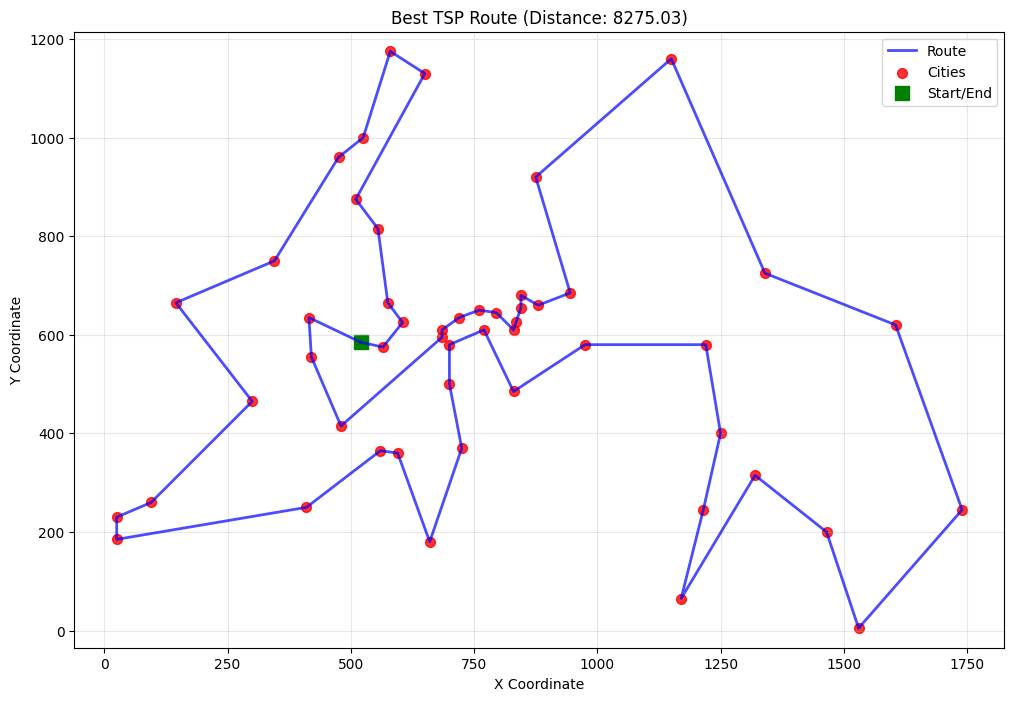

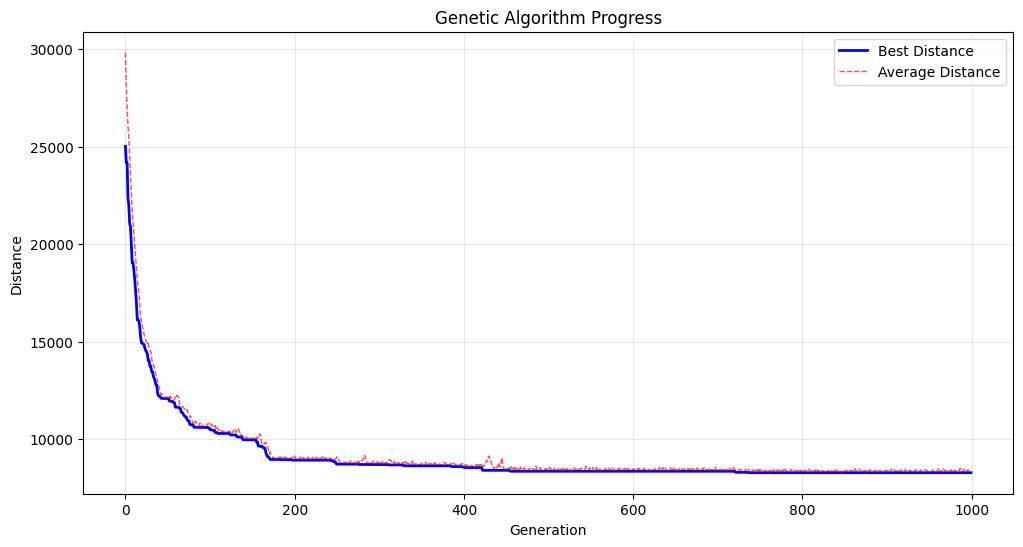


Detailed Statistics:
Initial best distance: 25016.09
Final best distance: 8275.03
Best route: [21, 17, 30, 22, 34, 35, 38, 39, 37, 47, 23, 4, 14, 5, 3, 42, 32, 50, 10, 51, 13, 12, 26, 46, 25, 27, 11, 24, 45, 36, 33, 43, 15, 28, 49, 19, 29, 1, 6, 41, 20, 16, 2, 40, 7, 8, 9, 18, 44, 31, 48, 0]
Number of cities: 52
Generations run: 1000

Additional Metrics:
Average improvement per 100 generations: 1674.11
Best distance found in generation: 736


In [22]:
# Plot the best route found
plot_route(cities, best_route, f"Best TSP Route (Distance: {final_distance:.2f})")

# Plot the algorithm progress
plot_progress(best_distances, avg_distances)

# Print detailed statistics
print(f"\nDetailed Statistics:")
print(f"Initial best distance: {best_distances[0]:.2f}")
print(f"Final best distance: {best_distances[-1]:.2f}")
print(f"Best route: {best_route}")
print(f"Number of cities: {len(cities)}")
print(f"Generations run: {len(best_distances)}")

# Calculate some additional metrics
print(f"\nAdditional Metrics:")
print(f"Average improvement per 100 generations: {(best_distances[0] - best_distances[-1]) / (len(best_distances) / 100):.2f}")
print(f"Best distance found in generation: {best_distances.index(min(best_distances))}")